In [14]:
from sklearn.feature_selection import SelectFromModel
import sksurv
from sksurv.ensemble import GradientBoostingSurvivalAnalysis
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Use GradientBoostingSurvivalAnalysis model for feature selection

In [3]:
# read imputed data
X = pd.read_csv('imputedX.csv',index_col=0)
# Read time and status
Y = pd.read_csv('Patient_data_NEJM.csv', index_col=0)
Y = Y.sort_index()
assert all(Y.index==X.index) # make sure that the index is the same
event = Y['Status at follow-up']=='Dead'
time = Y['Follow-up (years)']
structured = np.array([i for i in zip(event,time)],dtype=[('event',np.bool), ('time', np.float)])

In [4]:
GB = GradientBoostingSurvivalAnalysis()
GB.fit(X,structured)

GradientBoostingSurvivalAnalysis(criterion='friedman_mse', dropout_rate=0.0,
                 learning_rate=0.1, loss='coxph', max_depth=3,
                 max_features=None, max_leaf_nodes=None,
                 min_impurity_decrease=0.0, min_impurity_split=None,
                 min_samples_leaf=1, min_samples_split=2,
                 min_weight_fraction_leaf=0.0, n_estimators=100,
                 random_state=None, subsample=1.0, verbose=0)

In [10]:
GB.feature_importances_  
sum(GB.feature_importances_ >0)

428

In [17]:
FS = SelectFromModel(GB, prefit=True)
X_new = FS.transform(X)
print(X.shape)
print(X_new.shape)

(240, 7040)
(240, 380)


In [32]:
X_selected = X.loc[:,FS.get_support()]
X_selected.shape
X_selected.to_csv('selectedX.csv')

## Use GaussianMixture model and KM curve, PCA to check the effects

In [19]:
# GaussianMixture model
gm = GaussianMixture(n_components=3, verbose=1)
gm.fit(X_new)
Xpre = gm.predict(X_new)

Initialization 0
  Iteration 0
Initialization converged: True


(0, 10)

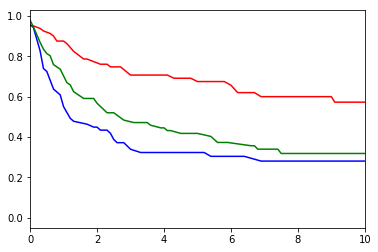

In [20]:
plt.plot(*sksurv.nonparametric.kaplan_meier_estimator(event[Xpre==0], time[Xpre==0]),c='r')
plt.plot(*sksurv.nonparametric.kaplan_meier_estimator(event[Xpre==1], time[Xpre==1]),c='b')
plt.plot(*sksurv.nonparametric.kaplan_meier_estimator(event[Xpre==2], time[Xpre==2]),c='g')
plt.xlim([0,10])

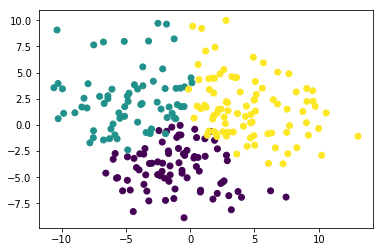

In [22]:
# Use PCA to see the effect
pca = PCA(svd_solver='full')
X1 = pca.fit_transform(X_new)
plt.scatter(X1[:,0],X1[:,1],c=Xpre)